# SVM with hog, color and LBP

## import libiraries

In [3]:
import numpy as np
import cv2
import tensorflow_datasets as tfds
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import random

## Load and split data

In [5]:
dataset, info = tfds.load('caltech101', with_info=True, as_supervised=True)

train_data = dataset['train']
test_data = dataset['test']

## Resize the image to a fixed size (for consistent feature extraction)


In [7]:
def resize_with_padding(image, target_size=(128, 128)):
    h, w = image.shape[:2]
    scale = min(target_size[1] / w, target_size[0] / h)
    resized_image = cv2.resize(image, (int(w * scale), int(h * scale)))
    
    delta_w = target_size[1] - resized_image.shape[1]
    delta_h = target_size[0] - resized_image.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_image

## Preprocess the data 



In [9]:
def process_data(data, image_size=(128, 128)):
    images = []
    labels = []

    for image, label in data:
        # Resize with padding
        image_resized = resize_with_padding(image.numpy(), image_size).astype('float32') / 255.0
        images.append(image_resized)
        labels.append(label.numpy())
    
    return np.array(images), np.array(labels)

## Preprocess the training and testing datasets


In [11]:
X_train, y_train = process_data(train_data, image_size=(64, 64))
X_test, y_test = process_data(test_data, image_size=(64, 64))

## Feature extraction: Combine color histogram and LBP features


In [13]:
def extract_combined_features(images, bins=32):
    features = []
    
    # Parameters for HOGDescriptor
    winSize = (32, 32)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9

    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

    for image in images:
        # Convert image to BGR format and grayscale
        image_bgr = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_RGB2BGR)
        gray_image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

        # Compute color histograms
        color_features = []
        for channel in range(3):  # B, G, R channels
            hist = cv2.calcHist([image_bgr], [channel], None, [bins], [0, 256])
            hist = cv2.normalize(hist, hist).flatten()
            color_features.append(hist)
        color_features = np.hstack(color_features)

        # Compute LBP features
        lbp = local_binary_pattern(gray_image, P=8, R=1, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins))
        lbp_hist = lbp_hist / lbp_hist.sum()  # Normalize

        # Compute HOG features
        hog_features = hog.compute(gray_image).flatten()

        # Concatenate all features
        combined_features = np.hstack((color_features, lbp_hist, hog_features))
        features.append(combined_features)
    
    return np.array(features)

##  Extract combined features




In [15]:
features_train = extract_combined_features(X_train, bins=32)
features_test = extract_combined_features(X_test, bins=32)
features_train.shape

(3059, 8228)

## Training the Kernel SVM model on the Training set



In [17]:
classifier = SVC(kernel='linear', random_state=0)
classifier.fit(features_train, y_train)


SVC(kernel='linear', random_state=0)

## Predict the labels for the test set


In [19]:
y_pred = classifier.predict(features_test)


## Calculate accuracy

In [21]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 65.67%


## Print classification report


In [23]:
print("\nClassification Report:")
print(classification_report(y_test.flatten(), y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        25
           1       0.98      0.95      0.96       770
           2       0.14      0.33      0.20        12
           3       0.00      0.00      0.00        12
           4       0.64      0.16      0.25       438
           5       0.23      0.41      0.30        17
           6       0.23      0.50      0.31        24
           7       0.05      0.19      0.08        16
           8       0.05      0.33      0.08         3
           9       0.55      0.36      0.43        98
          10       0.58      0.51      0.55        68
          11       0.08      0.15      0.10        13
          12       0.61      0.64      0.62        55
          13       0.51      0.46      0.48        61
          14       0.29      0.50      0.36        20
          15       0.08      0.31      0.13        13
          16       0.97      0.99      0.98        93
   

## Visualize a random image, its HOG features, and the SVM prediction


In [25]:
def show_image_with_all_features(images, labels, classifier, bins=32):
    # Select a random image index
    index = random.randint(0, len(images) - 1)
    original_image = (images[index] * 255).astype('uint8')
    true_label = labels[index]
    
    # Extract features for the selected image
    image_bgr = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)
    gray_image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    
    # Compute color histogram features
    color_features = []
    histograms = []
    for channel, color in enumerate(['b', 'g', 'r']):  # B, G, R channels
        hist = cv2.calcHist([image_bgr], [channel], None, [bins], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        color_features.append(hist)
        histograms.append((hist, color))
    color_features = np.hstack(color_features)

    # Compute LBP features
    lbp = local_binary_pattern(gray_image, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins))
    lbp_hist = lbp_hist / lbp_hist.sum()  # Normalize

    # Compute HOG features
    hog_features = cv2.HOGDescriptor(
        (32, 32), (16, 16), (8, 8), (8, 8), 9).compute(gray_image).flatten()
    
    # Concatenate features
    combined_features = np.hstack((color_features, lbp_hist, hog_features))
    
    # Predict the label
    predicted_label = classifier.predict([combined_features])[0]
    
    # Visualize the original image and features
    plt.figure(figsize=(18, 12))
    
    # Original image
    plt.subplot(3, 3, 1)
    plt.imshow(original_image)
    plt.title(f"Original Image\nTrue Label: {true_label}")
    plt.axis("off")
    
    # Color histogram visualization
    plt.subplot(3, 3, 2)
    for hist, color in histograms:
        plt.plot(hist, color=color)
    plt.title("Color Histogram (B, G, R Channels)")
    plt.xlabel("Bins")
    plt.ylabel("Normalized Frequency")
    plt.grid()
    
    # LBP visualization
    plt.subplot(3, 3, 3)
    plt.imshow(lbp, cmap="gray")
    plt.title("LBP Features\n(Part of Concatenated Features)")
    plt.axis("off")
    
    # HOG visualization (reshape to visualize as an image)
    plt.subplot(3, 3, 4)
    hog_image = hog_features[:1024].reshape((32, 32))  # Take part of HOG features
    plt.imshow(hog_image, cmap="gray")
    plt.title("HOG Features\n(Visualized)")
    plt.axis("off") 
    # Prediction visualization
    plt.subplot(3, 3, 6)
    plt.imshow(original_image)
    plt.title(f"Prediction: {predicted_label}\nTrue Label: {true_label}")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()


## Display a random image, its HOG features, and the prediction


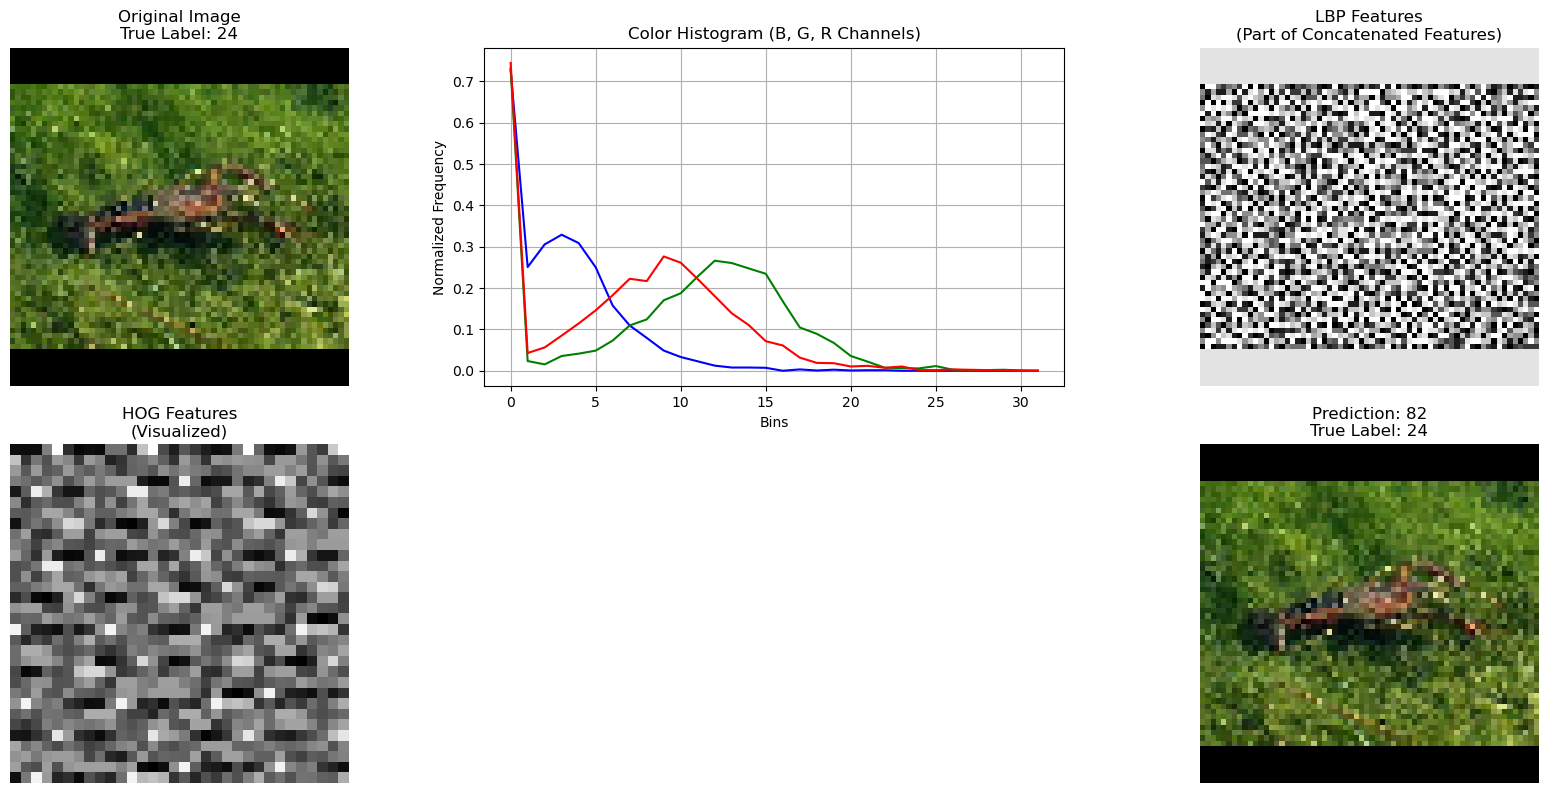

In [27]:
show_image_with_all_features(X_test, y_test, classifier, bins=32)